# Load in models:

In [1]:
import os
from transformers import CLIPProcessor, CLIPModel
import clip
import torch
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
import matplotlib.pyplot as plt

import PIL
from PIL import Image
import requests

%load_ext autoreload
%autoreload 2

In [2]:
# Intialize CLIP model
clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# can also laod from github

2023-07-05 22:33:34.808754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# # Initialize SAM model
# model_type = "vit_b"
# sam_checkpoint = os.path.expanduser("/home/ibm-work/segment-anything/models/sam_vit_b_01ec64.pth")
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(device)

# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)
# sam_predictor = SamPredictor(sam)

In [4]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
clipseg_processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

# Load in some images

In [5]:
# url_dict = {}
# with open("urls.txt") as f:
#     url_classes = f.readline()
#     pieces = url_classes.split("|")
#     url = str(pieces[0])
#     classes = [el.strip() for el in pieces[1].split(",")]
#     url_dict[url] = classes

In [6]:
import utils

In [7]:
url = "https://phlearn.com/wp-content/uploads/2018/11/image5-1.jpg"
vocab = ["pole", "dog", "window", "person", "telephone booth", "road", "sign", "cat", "car", "lamp", "tree"]
vocab = utils.deserialize("/home/ibm-work/data/coco_objects/coco_labs.obj") + vocab
image = Image.open(requests.get(url, stream=True).raw)

In [8]:
from clip_sam_helper import clip_inference, clip_inference_chunks
probs_whole = clip_inference(clip, clip_processor, image, vocab)
probs_chunk = clip_inference_chunks(clip, clip_processor, image, vocab)

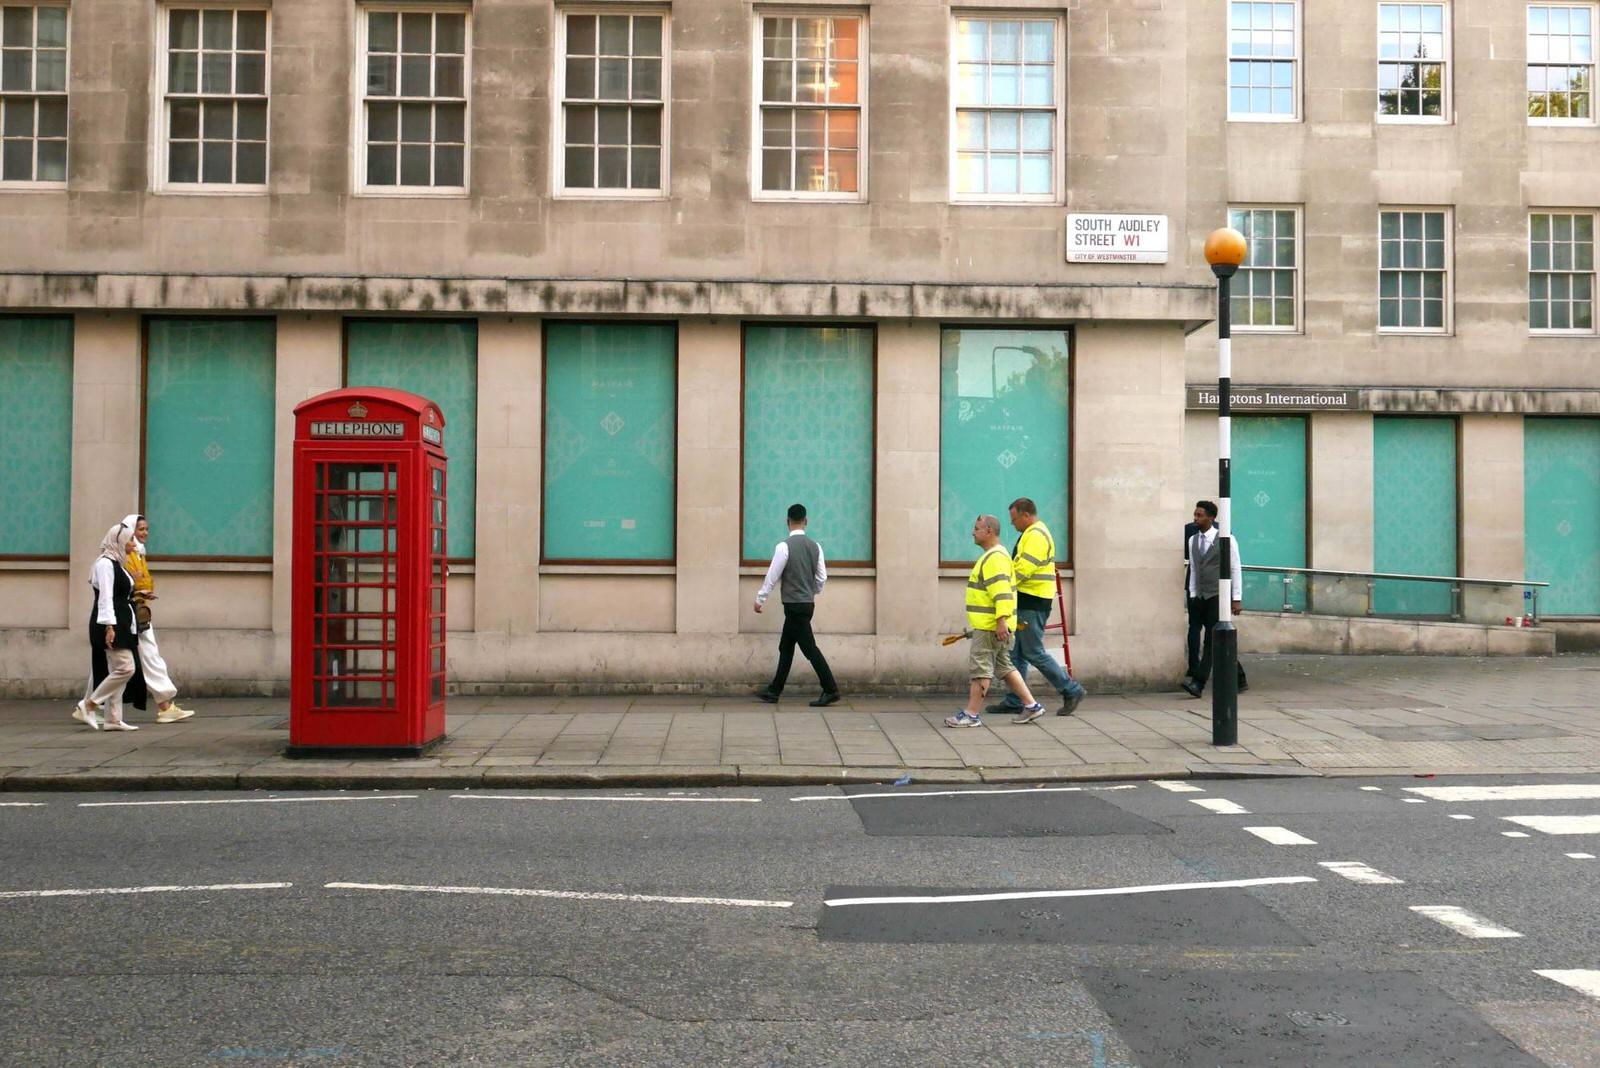

Vocab too large to display all labels... displaying top 10
telephone booth -- 0.9548186659812927
traffic light -- 0.032064493745565414
door -- 0.0025450964458286762
parking meter -- 0.0016513345763087273
cell phone -- 0.0016494521405547857
pole -- 0.0012509824009612203
fire hydrant -- 0.000599318474996835
toilet -- 0.00030273429001681507
handbag -- 0.00028463511262089014
suitcase -- 0.00023877009516581893


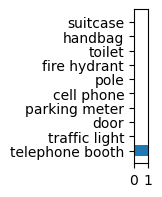

In [9]:
from clip_sam_helper import display_bars, display_image
display_image(image)
display_bars(probs_whole, vocab)

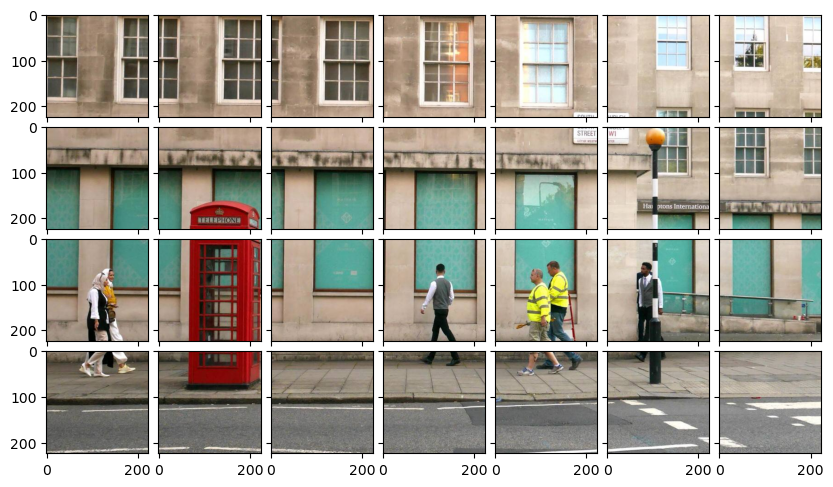

Vocab too large to display all labels... displaying top 10


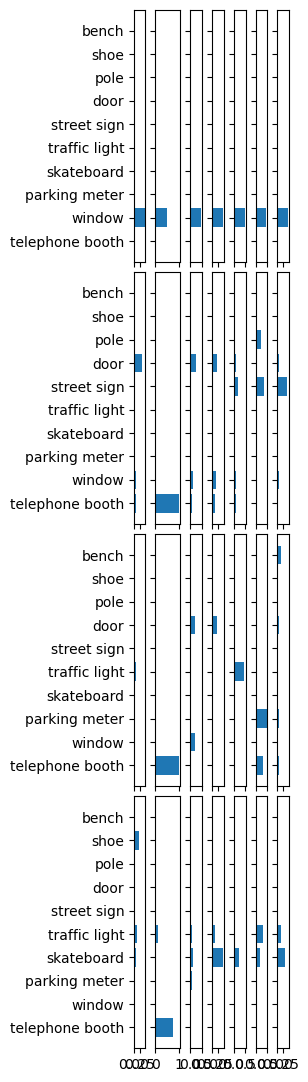

In [10]:
dims = display_image(image, mode="chunks")
display_bars(probs_chunk, vocab, mode="chunks", dims=dims)

# Extract max probability per entity

In [13]:
from clip_sam_helper import extract_entities
entities_dict, entities_dict_whole, entities_dict_chunk = extract_entities(probs_whole, probs_chunk, vocab)
entities_dict_whole

{'dining table': 1.5789350072736852e-05,
 'book': 5.42116686119698e-05,
 'fire hydrant': 0.000599318474996835,
 'cake': 3.8178832255653106e-06,
 'toilet': 0.00030273429001681507,
 'hot dog': 9.848078661889303e-06,
 'bear': 9.182167559629306e-06,
 'fork': 1.4269060557126068e-05,
 'hair drier': 3.0009990950929932e-05,
 'dog': 1.3791430319542997e-05,
 'orange': 9.659133502282202e-05,
 'street sign': 0.000107204781670589,
 'bicycle': 0.00014744271175004542,
 'snowboard': 2.040772642430966e-06,
 'chair': 0.0001343062613159418,
 'hat': 1.1338572221575305e-05,
 'suitcase': 0.00023877009516581893,
 'person': 0.0002300718770129606,
 'sheep': 2.2622807591687888e-05,
 'toaster': 2.3134745788411237e-05,
 'scissors': 8.927276212489232e-05,
 'tennis racket': 5.685440100933192e-06,
 'door': 0.0025450964458286762,
 'eye glasses': 6.055678386474028e-05,
 'bed': 2.722565341173322e-06,
 'bowl': 6.889349151606439e-06,
 'laptop': 9.306117135565728e-06,
 'horse': 1.4798895790590905e-05,
 'remote': 9.6173294

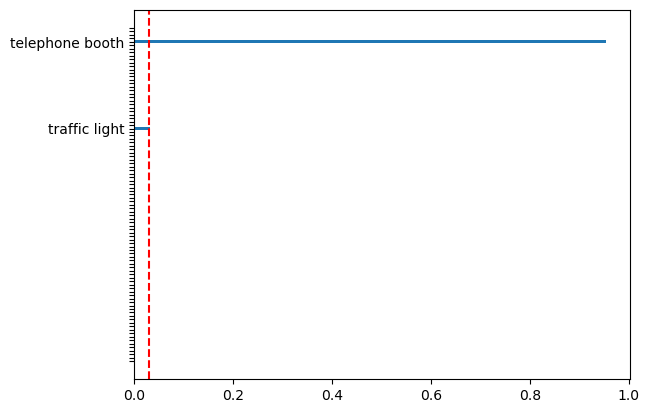

In [14]:
D = entities_dict_whole
thresh = 0.03
plt.barh(range(len(D)), list(D.values()), align='center')
labs = [item[0] if item[1] > thresh else "" for item in D.items()]
plt.yticks(range(len(D)), labs)
plt.axvline(x=thresh, color='r', linestyle='--')
plt.show()


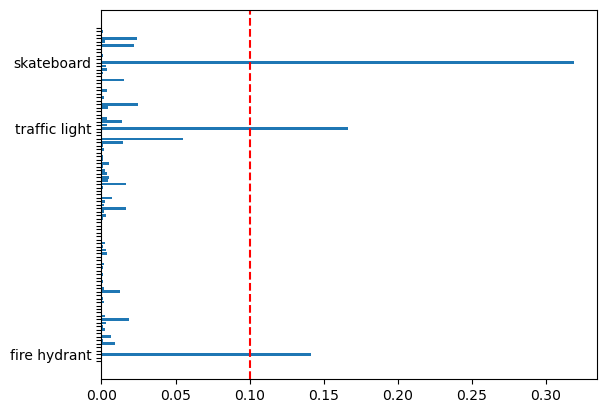

In [17]:
D = entities_dict_chunk
thresh = 0.03
plt.barh(range(len(D)), list(D.values()), align='center')
labs = [item[0] if item[1] > thresh else "" for item in D.items()]
plt.yticks(range(len(D)), labs)
plt.axvline(x=thresh, color='r', linestyle='--')
plt.show()

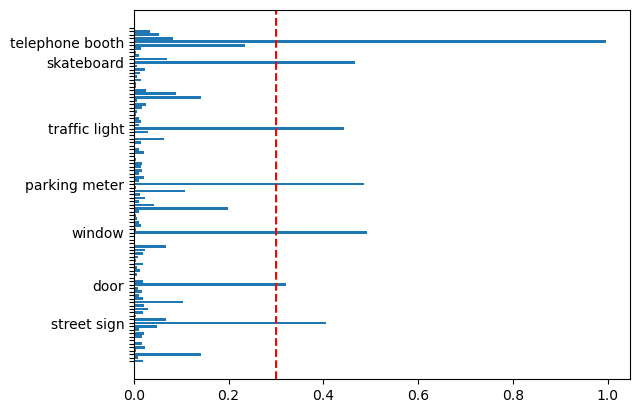

In [16]:
D = entities_dict
thresh = 0.3
plt.barh(range(len(D)), list(D.values()), align='center')
labs = [item[0] if item[1] > thresh else "" for item in D.items()]
plt.yticks(range(len(D)), labs)
plt.axvline(x=thresh, color='r', linestyle='--')
plt.show()

Using probability threshold of 0.5
Label prompts with high probability: ['telephone booth']
Overwriting to CPU run on CLIPSeg inference...


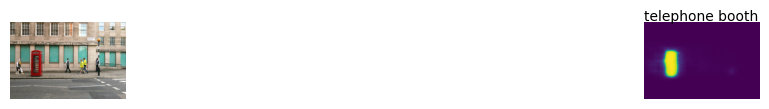

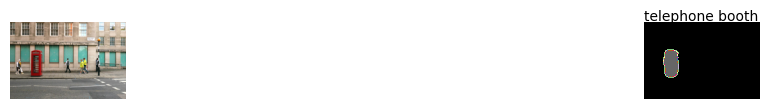

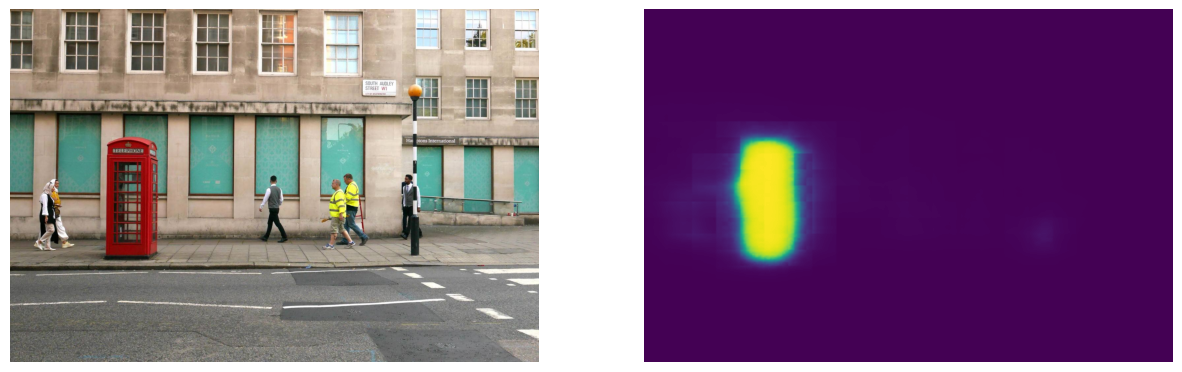

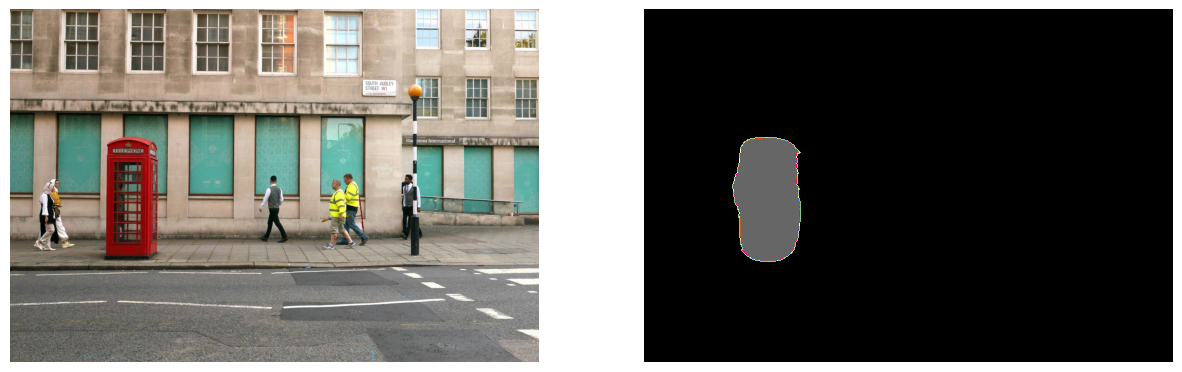

In [31]:
from clip_sam_helper import clipseg_aggregate
ed = entities_dict

full_mask, vmax = clipseg_aggregate(clipseg, clipseg_processor, image, ed, viz_flag=True) 

# Analyze potential "hallucination" from CLIPSeg

In [32]:
from clip_sam_helper import clipseg_hallucination_viz, clipseg_inference

ed = entities_dict
text_list = list(ed.keys())
masks = clipseg_inference(clipseg, clipseg_processor, image, text_list)

Overwriting to CPU run on CLIPSeg inference...


### First we take a look at the list of entities and probabilities from CLIP applied to the whole image

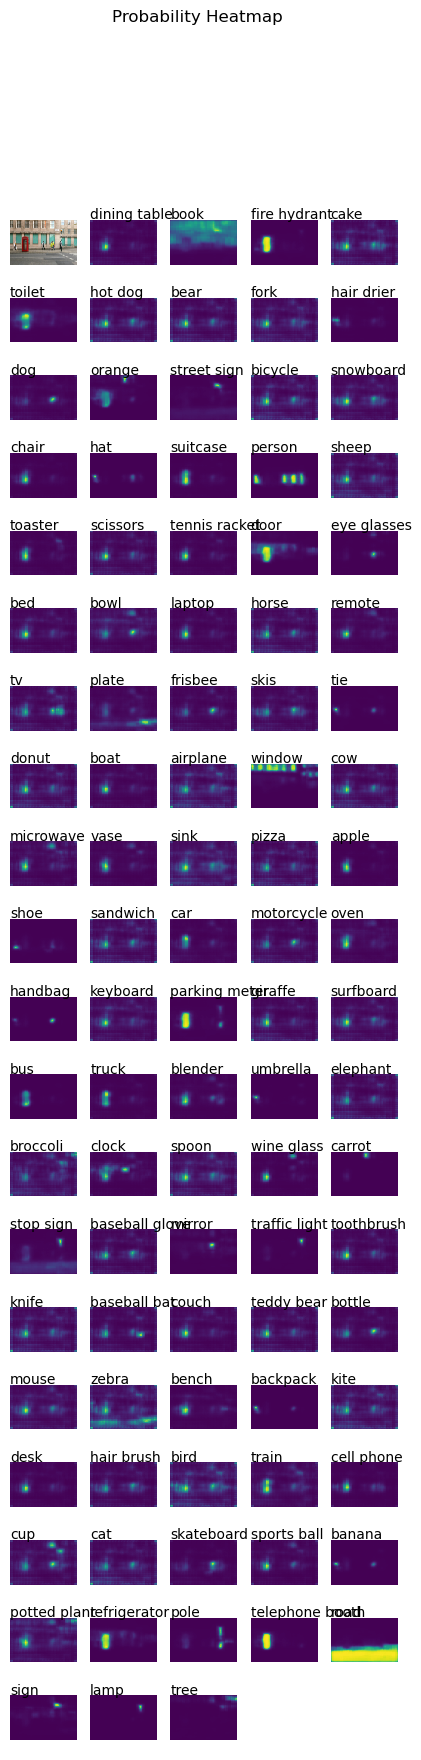

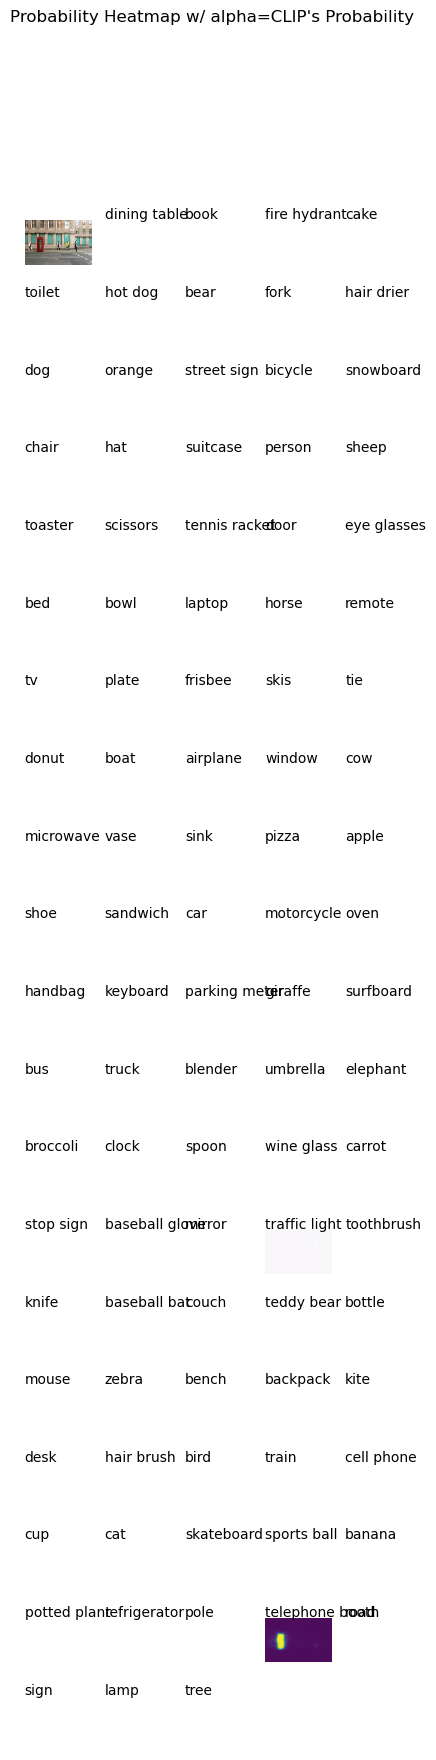

In [34]:
ed = entities_dict_whole
clipseg_hallucination_viz(image, masks, ed) 

### Next, we take a look at the combined approach of CLIP on images and image chunks -- where the max probability is taken for both methods.

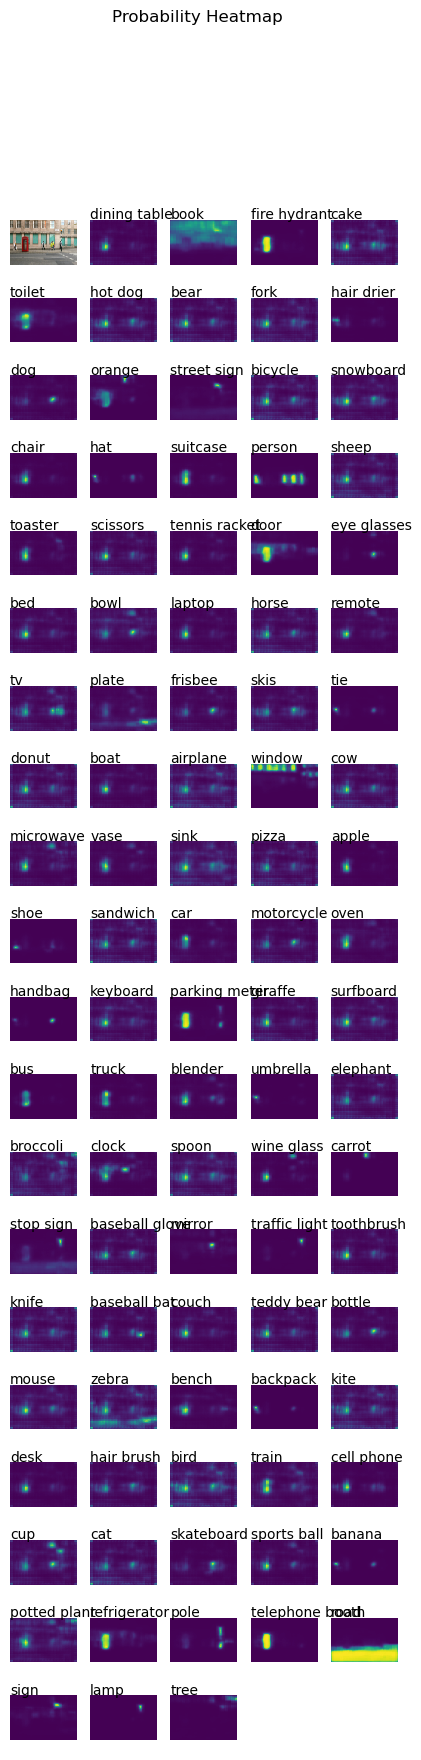

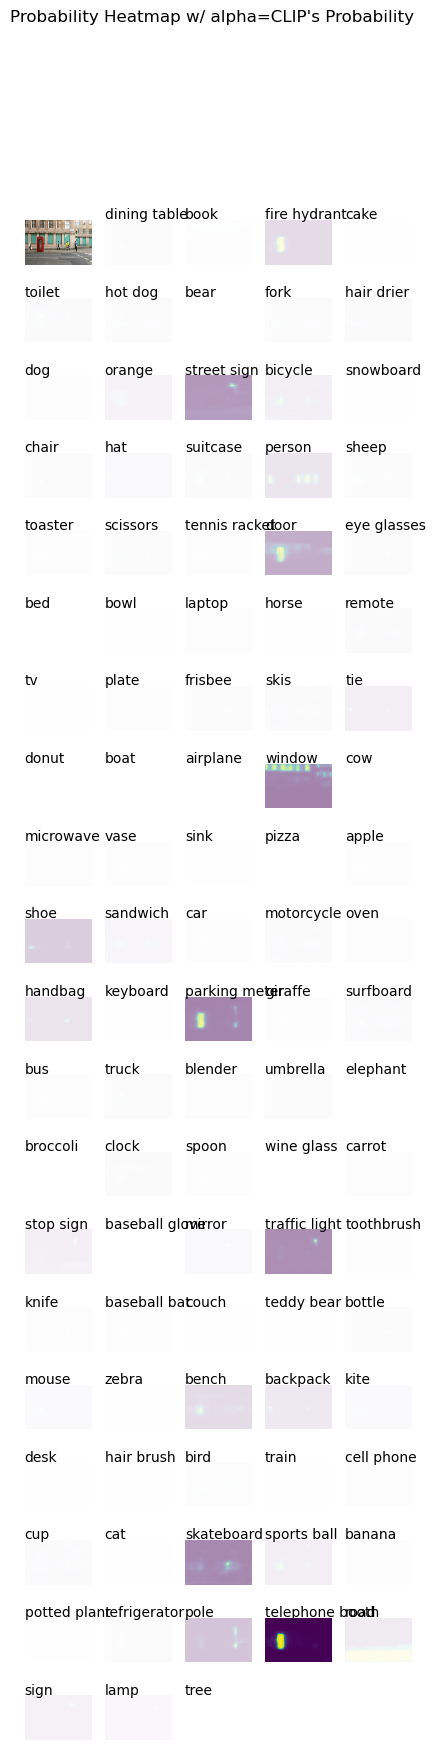

In [33]:
ed = entities_dict
clipseg_hallucination_viz(image, masks, ed) 

# Studying Label set size and CLIP confidence

In [35]:
vocab = ["pole", "dog", "window", "person", "road", "sign", "cat", "car", "lamp", "tree"]
vocab = utils.deserialize("/home/ibm-work/data/coco_objects/coco_labs.obj") + vocab
target = ["telephone booth"]

In [36]:
len(vocab + target)

102

In [40]:
import pdb
import numpy as np
import matplotlib.pyplot as plt

In [52]:
np.random.seed(0)
counts = []
to_run = list(range(4,104,5)) + [101]

for num_labels in to_run:
    expected_prob = 1 / (num_labels + 1)
    vocab_sample = list(np.random.choice(vocab, size=num_labels, replace=False)) + target
    probs_whole = clip_inference(clip, clip_processor, image, vocab_sample).cpu().detach().numpy()
    counter = 0
    for p in list(probs_whole[0]):
        if p > expected_prob:
            counter += 1
    counts.append(counter)
    

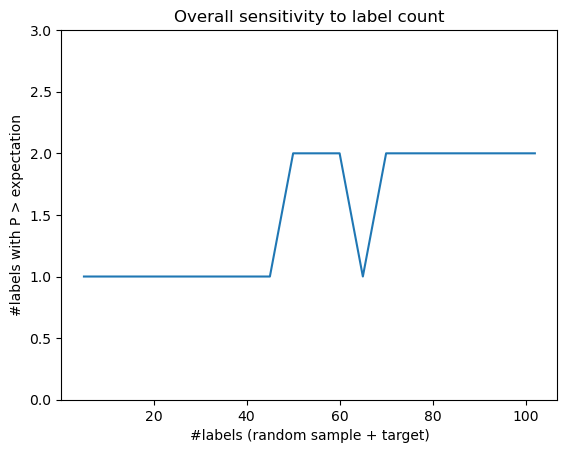

In [60]:
to_run1 = [l+1 for l in to_run]

plt.figure()
plt.plot(to_run1, counts)
plt.title("Overall sensitivity to label count")
plt.ylim([0, int(np.max(counts))+1])
plt.ylabel("#labels with P > expectation")
plt.xlabel("#labels (random sample + target)")
plt.show()


In [58]:
np.random.seed(0)
p_telbooth = []
to_run = list(range(4,104,5)) + [101]

for num_labels in to_run:
    expected_prob = 1 / (num_labels + 1)
    vocab_sample = list(np.random.choice(vocab, size=num_labels, replace=False)) + target
    probs_whole = clip_inference(clip, clip_processor, image, vocab_sample).cpu().detach().numpy()
    p_dict = dict(zip(vocab_sample, list(probs_whole[0])))
    p_tb = p_dict["telephone booth"]
    p_telbooth.append(p_tb)

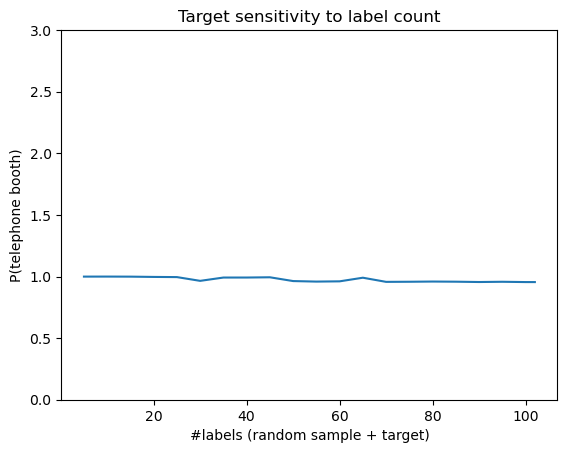

In [59]:
to_run1 = [l+1 for l in to_run]

plt.figure()
plt.plot(to_run1, p_telbooth)
plt.title("Target sensitivity to label count")
plt.ylim([0, int(np.max(counts))+1])
plt.ylabel("P(telephone booth)")
plt.xlabel("#labels (random sample + target)")
plt.show()